# Week 7 - Logistic regression
by Colin Rundel & David Elliott & Ozan Evkaya

1. [Setup](#setup)

2. [Binary Logistic Regression](#RBH)

3. [Model refinement](#refine)

4. [Multi-class Example](#mclog)

5. [Regularization Example](#SKV)



This week we will be implementing the logistic regression techniques from this weeks lecture in python. We will start with the binary case and then look at some extensions of the logistic regression model

---

# 1. Setup <a id='setup'></a>

## 1.1. Uploading your data to the colab
This notebook will be saved in your google drive in a folder "Colab Notebooks" by default, you should be fairly familiar with this by now.

When you run this cell you will need to give colab permission to access files in your drive.

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/mlp/week-7')
!ls

Mounted at /content/drive
week07.ipynb  week-07.zip  ws-material


We will now unzip the workshop materials and place them in a subdirectory "ws-material/"

In [ ]:
if not os.path.exists('ws-material'):
  print('Unzipping materials...')
  !unzip week-07.zip -d ws-material
else:
  print("Directory already exists!")

os.chdir('ws-material')
!ls

Directory already exists!
week-07


__Reminder__ 

- You may need to restart the runtime several times in the workshop, but you will not need to re-upload or unzip files again. 

## 1.2 Packages

Now lets load in the packages you wil need for this workshop.

In [ ]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

# Other necessary packages
from sklearn.datasets import load_iris           # for the Iris data
from IPython.display import Image                # displaying .png images
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding
from sklearn.pipeline import Pipeline            # combining classifier steps
from sklearn.preprocessing import PolynomialFeatures # make PolynomialFeatures
import warnings # prevent warnings
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from scipy.stats.distributions import uniform, loguniform

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.metrics import classification_report_imbalanced
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



##  Helper Functions

Below are two helper functions we will be using in this workshop.

In [ ]:
# tidy the output into a dataframe
def tidy_scores(score_dict):
    df = pd.DataFrame(score_dict)
    df.loc['mean'] = df.mean()
    df.loc['sd'] = df.std()
    df.rename({"test_score":"val_score"}, axis=1, inplace=True)
    df.index.name = "fold"
    return df.round(2)


# this creates the matplotlib graph to make the confmat look nicer
# IT WORKS FOR ONLY BINARY CLASSIFICATION CASE !
def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):

    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()
  
# For ROC curve plotting function

def roc_plot(threshold=0.5):
    i = (np.abs(roc.threshold - threshold)).idxmin()

    sns.lineplot(x='false positive rate', y='true positive rate', data=roc, ci=None)

    plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
    plt.plot(roc.iloc[i,0], roc.iloc[i,1], 'r.')

    plt.title("threshold = %.2f" % threshold)
    plt.show()

# For iris data example 

def species_label(theta):
	if theta==0:
		return raw_data.target_names[0]
	if theta==1:
		return raw_data.target_names[1]
	if theta==2:
		return raw_data.target_names[2]

## 1.3 Data

The dataset consists of 10000 individuals and whether their credit card has defaulted or not. Below is the column description: The main aim is to build the model using Logistic Regression and predict the accuracy of it. The included columns in the data set are as follows:

* `default` - Whether the individual has defaulted

* `student` - Whether the individual is the student

* `balance` - The balance in the individual's account

* `income` - Income of an individual

We read the data into python using pandas.





In [ ]:
df_default = pd.read_csv("./week-07/Data/Default.csv", index_col=0)

# for now lets just drop the student varible.
df_default = df_default.drop("student", axis=1)
df_default.head()

,default,balance,income
1,No,729.526495,44361.62507
2,No,817.180407,12106.13470
3,No,1073.549164,31767.13895
4,No,529.250605,35704.49394
5,No,785.655883,38463.49588


We will begin by doing explanatory data analysis to examine the data set itself

---

### 🚩 Exercise 1

Examine the structure of the data. Answer the following questions simply;

1. Do you observe anything of note from descriptive statistics that may influence our models?
2.  Are there any missing values? 
3. Look at how the varibles relate to each other (Response: Default, Predictors: Balance and Income)

In [ ]:
#About data info 
print(df_default.info())

# Some descriptive statistics
# We invoke the .T to transpose the matrix for better viewing 
print(df_default.describe().T)

# Checking the missing values
print(df_default.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   balance  10000 non-null  float64
 2   income   10000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 312.5+ KB
None
           count          mean           std         min           25%  \
balance  10000.0    835.374886    483.714985    0.000000    481.731105   
income   10000.0  33516.981876  13336.639563  771.967729  21340.462905   

                  50%           75%           max  
balance    823.636973   1166.308387   2654.322576  
income   34552.644800  43807.729275  73554.233500  
default    0
balance    0
income     0
dtype: int64


---

Firstly, the range of the features should be considered carefully since their scale is different. For that reason, classical StandardScaler can be used before using in the model construction. Apart from that, there is no missing value to deal with.  

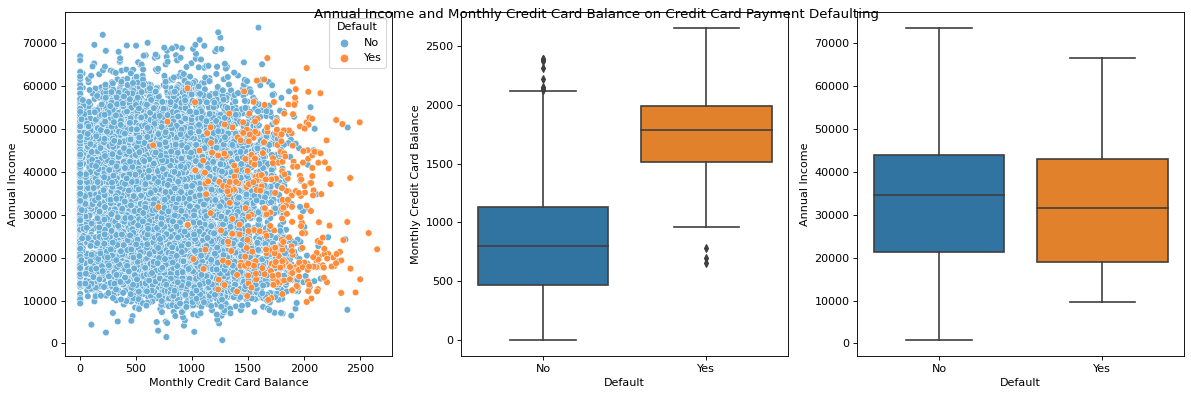

In [ ]:
# How variables are related to each other 

balance_label = "Monthly Credit Card Balance"
income_label = "Annual Income"
default_label = "Default"

fig, axes = plt.subplots(ncols = 3, figsize=(15,5))

# Main scatterplots and boxplots for each feature in terms of response 
sns.scatterplot(data = df_default[df_default['default']=="No"], x = "balance", y="income", hue="default", palette='Blues',ax=axes[0])
sns.scatterplot(data = df_default[df_default['default']=="Yes"], x = "balance", y="income",hue="default", palette='Oranges',ax=axes[0])
sns.boxplot(data = df_default, x = "default", y="balance", ax=axes[1])
sns.boxplot(data = df_default, x = "default", y="income", ax=axes[2])

axes[0].legend(title=default_label)
axes[0].set_xlabel(balance_label)
axes[0].set_ylabel(income_label)
axes[1].set_xlabel(default_label)
axes[1].set_ylabel(balance_label)
axes[2].set_xlabel(default_label)
axes[2].set_ylabel(income_label)

plt.suptitle("Annual Income and Monthly Credit Card Balance on Credit Card Payment Defaulting")
plt.tight_layout()
plt.show()

*It appears that individuals who defaulted tended to have higher credit card 
balances than those who did not."* In terms of the annual income, the variability is higher for the individiauls who did not default compared to defaulted ones. Different scales for the features can be seen in the boxplots as well (y-axis values). Additionally, in the scatter plot there is an indication that the classical linear classification tool might be limited because of how the points are spreaded out (Just to keep in mind, not for changing the model structure)

---

### 🚩 Exercise 2

1. Lets now create our feature matrix and response varible.
2.  Split the data into training and test sets (**Is there anything you should try account for when splitting the data ?**)
3. Convert your response variable into the numerical format



In [ ]:
# Feature matrix and response separation 
data_x, data_y = df_default.drop(['default'], axis=1), df_default['default']

print(data_x.shape)
print(data_y.shape)

# Before Splitting the data set 
print("Class Distribution (%)")
# get our null accuracy rate 
data_y.value_counts(normalize=True)*100

(10000, 2)
(10000,)
Class Distribution (%)


No     96.67
Yes     3.33
Name: default, dtype: float64

---

As can be seen above, we have an imbalance data problem in our responce varible which we should try keep proportional in our test set. For this reason, you need to use the additional argument inside of `train_test_split` function, stratify in terms of the response data set. Otherwise, without stratify argument, the class proportions in train and testing will be different and it might be problem for building the model on imbalanced data set, like default

Afterwars, we will be careful about that while we are measuring the performance of the model later !


`

In [ ]:
from sklearn.model_selection import train_test_split

features = list(data_x.columns)
X_train, X_test, y_train, y_test = train_test_split(data_x.values, data_y.values, stratify = data_y, 
                                                    test_size = 0.1, random_state=42)


# TO CHECK: The same proportion is satisfied for both train and test data sets 
print(pd.Series(y_train).value_counts(normalize=True)*100)
print(pd.Series(y_test).value_counts(normalize=True)*100)

No     96.666667
Yes     3.333333
dtype: float64
No     96.7
Yes     3.3
dtype: float64


In [ ]:
#Converting the response variable 
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)

#Some of the observations that we have, type is numpy array so be careful about the use of head !
y_train[:10],y_test[:10]


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0]))

---

### 🚩 Exercise 3

Fit a binary logistic regression model to the training data by using both balance and income as features, without any regularization. State the the accuracy score of the model over the testing data

For the details of the function check out 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
from sklearn.linear_model import LogisticRegression
logfit = LogisticRegression(random_state=42, penalty="none").fit(X_train, y_train)

# print(logfit.get_params())

print(logfit.score(X_test,y_test))


0.974


This result is a bit expected because of the imbalance data problem. If we just look at the accuracy, we can miss the FP ratios so that the accuracy checking is not enough. We will have a look at the confusion matrix details.

## Model Predictions

Unlike with our previous regression models, the fitted LogisticRegression objects provide multiple prediction methods. Specifically: predict which predicts the class label (either 0 or 1), predict_proba which predicts the class probabilities, and predict_log_proba which predicts the log probabilities of each class


---

### 🚩 Exercise 4

Based on the above fitted logistic regression model, calculate

1. the predictions of the class probabilities
2. Calculate the mean squared error, accuracy score, AUC score of your logistic regression model's predictions. The function `mean_squared_error` , `accuracy_score` and `roc_auc_score` from `sklearn.metrics` will be useful for this. See the functions documentation if you need [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [ ]:
# For class probabilities
print(logfit.predict_proba(X_test))


[[9.98782554e-01 1.21744641e-03]
 [9.99788693e-01 2.11307383e-04]
 [9.38444407e-01 6.15555925e-02]
 ...
 [9.84910073e-01 1.50899269e-02]
 [9.99659584e-01 3.40416290e-04]
 [9.96903740e-01 3.09625950e-03]]


Based on the calculated class probability predictions, our model always predicted the response as 0 (generally, larger values in the first column and very small probabilities in the second column)

In [ ]:
# Necessary packages
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

#In terms of testing data 
print("MSE of the fitted model:", mean_squared_error(y_test, logfit.predict(X_test)))
print("Accuracy of the fitted model:", accuracy_score(y_test, logfit.predict(X_test)))
print("AUC of the fitted model:", roc_auc_score(y_test, logfit.predict(X_test)))

#In terms of valid data 

MSE of the fitted model: 0.026
Accuracy of the fitted model: 0.974
AUC of the fitted model: 0.679232866409702


If we just look at the accuracy of the model we will interpreted the result incorrect because of the imbalanced data set problem. While MSE is low and AUC seems reasonable rather than the model at a chance, we need to check the quantities in confusion matrix for fair assessment. Besides, the above model used only one training data set, so we need cross-validation idea to see the differences when we change the training / testing data set partitioning 

---

### 🚩 Exercise 5

Create a pipeline for the logistic regression model simply. Consider 5-fold Cross Validation for this calculation and use the helper function tidy_scores() created above for average score calculation

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps

# One can add more model in the dictionary
model_dict = {"log": LogisticRegression(random_state=42, penalty="none")}

#print(model_dict[model_name]) 

for model_name in model_dict:
    linear_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model_dict[model_name])])
    
scores = tidy_scores(cross_validate(linear_pipe, X_train, y_train, cv=5, return_train_score=True))

# For all CV results
print(scores)

#Just the mean and sd values overall
print(scores.loc[['mean', 'sd']])

      fit_time  score_time  val_score  train_score
fold                                              
0         0.03         0.0       0.97         0.97
1         0.02         0.0       0.97         0.97
2         0.02         0.0       0.97         0.97
3         0.02         0.0       0.97         0.97
4         0.02         0.0       0.98         0.97
mean      0.02         0.0       0.97         0.97
sd        0.00         0.0       0.00         0.00
      fit_time  score_time  val_score  train_score
fold                                              
mean      0.02         0.0       0.97         0.97
sd        0.00         0.0       0.00         0.00


## Performance Metrics

A binary classifier can make two types of errors:

- Incorrectly assign an individual __who defaults__ to the __no default__ category.
- Incorrectly assign an individual who __does not default__ to the __default__ category.

While the overall error rate is low, the error rate among individuals who defaulted is very high. From the perspective of a credit card company that is trying to identify high-risk individuals, this error rate among individuals who default may well be unacceptable.

---

### 🚩 Exercise 6

Derive the confusion matrix for the logistic regression model with two predictors by following the below pipeline. Afterwards, derive the followings;

1. False Positive Rate (FPR)
2. True Positive Rate (Recall)
3. Precision
4. F1-score

without using any additional built-in function from any module (You need to recall the definitions from our notes) 

Note that,

$$
\text{FPR} = \frac{\text{FP}}{\text{FP}+ \text{TN}}
$$

$$
\text{Recall} = \frac{\text{TP}}{\text{TP}+ \text{FN}}
$$

$$
\text{Precision} = \frac{\text{TP}}{\text{TP}+ \text{FP}}
$$

$$
F1 = 2\left(\frac{Precision \times Recall}{Precision + Recall}\right)
$$

What can you say about the model performance in terms of Confusion Matrix and obtained quantities ? Be careful about the locations of true and estimated class labels in the output figure !!!

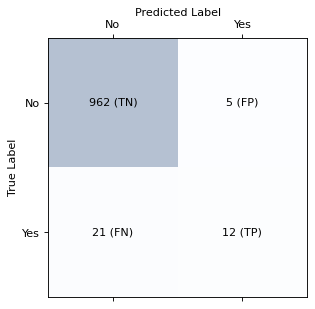

In [ ]:
from sklearn.metrics import confusion_matrix

log_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(random_state=42, penalty = "none"))])

log_pipe.fit(X_train, y_train)

# use the classifier to predict the validation set    
# predictions = log_pipe.predict(X_val)
predictions = log_pipe.predict(X_test)

# get the confusion matrix as a numpy array
#confmat = confusion_matrix(y_true=y_val, y_pred=predictions)
confmat = confusion_matrix(y_true = y_test, y_pred=predictions)

# Just a direct output for the confusion matrix  
# confmat

# use the pretty function to make it nicer, you can give some name for LE.classes_ inside of the function
pretty_confusion_matrix(confmat, LE.classes_, "",  labeling=True)

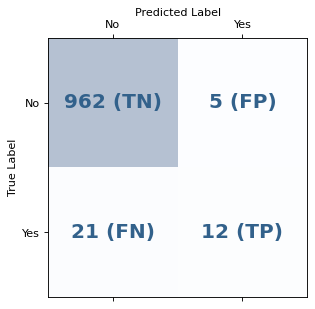

False Positive Rate (FPR): 0.005
Recall: 0.364
Precision: 0.706
F1 Score: 0.480


In [ ]:
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)


pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)


Here, the confusion matrix content implies an important issue about the values of FN. Basically, FN > TP in that output, as a result Recall value is really small for that logistic fit trial. Because of the that F1 score is also around 0.5. Since we have the imbalanced data set, somehow we need to improve our model in a way that more reasonable Recall value should be derived at the end (Increasing TP and decreasing FN values, of course it can effect TN, FP values based on the our search)

**F1-score**

- F1-score is a combination of Recall and Precision. 
- It is typically used when there is an __uneven class distribution__ due to a large number of True Negatives that you are not as focused on. 

$$
F1 = 2\left(\frac{PRE \times REC}{PRE + REC}\right)
$$

__Notes__

- Using `sklearn.metrics` this can be gained using `f1_score(y_true=y_val, y_pred=predictions)`

---

### 🚩 Exercise 7

1. Calculate the $F1$ score using *f1_score* function for the logistic regression model with two predictors and compare your result with your calculation obtained in Q4 in Exercise 5 above ! 
2. Draw ROC and Precision-Recall Curve for the same model. Explain the obtained graphical results and state the difference.  

In [ ]:
# By using the available function
from sklearn.metrics import f1_score

f1_score(y_true=y_test, y_pred=predictions)


0.48000000000000004

   false positive rate  true positive rate  threshold
0             0.000000            0.000000        2.0
1             0.005171            0.363636        1.0
2             1.000000            1.000000        0.0
AUC value: 0.679232866409702


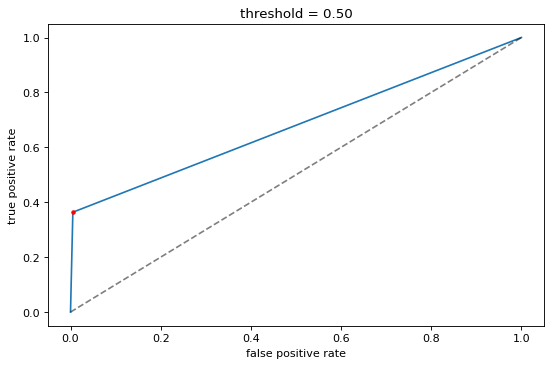

In [ ]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, precision_recall_curve

roc_calc = roc_curve(y_true = y_test, y_score = predictions)
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)

# Values for ROC based on different threshold 
print(roc)

#Print the related AUC value 
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions))

#ROC curve drawing by using the helper function roc_plot above

roc_plot(threshold=0.5)


Using this data frame, the function below creates the ROC curve (blue) via a seaborn lineplot, while the remaining code draws the point on the ROC curve that corresponds to the given threshold value (red), and finally the 0-1 line (grey, dashed)

As we decrease the threshold, the red dot moves up and to the right - this makes sense as increasing this threshold will increase both the TPR and the FPR.

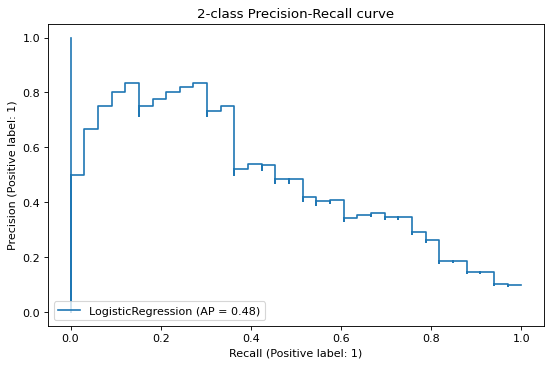

In [ ]:
#precision_recall_curve(y_val, predictions)
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(log_pipe, X_test, y_test, name="LogisticRegression")
_ = display.ax_.set_title("2-class Precision-Recall curve")

# OR Alternatively 
# using the classifier.decision_function
# classifier = log_pipe
# y_score = classifier.decision_function(X_test)

# display = PrecisionRecallDisplay.from_predictions(y_test, y_score, name="LogisticRegression")
# _ = display.ax_.set_title("2-class Precision-Recall curve")

---

**!!! Add your comments here !!!**


__Notes__

- For further reading on different performance metrics see David M. W. Powers' technical report [Evaluation: From Precision,  Recall and F-Factor to ROC, Informedness, Markedness & Correlation](https://arxiv.org/ftp/arxiv/papers/2010/2010.16061.pdf)

## Model Refinement

For those coming from other programming / modeling languages this may be somewhat surprising, this strange default is probably the most common reason that results from sklearn might not immediately match results from other tools. This behavior can be explicitly controlled via the penalty argument. Note that if you did wish to include a penalty on the coefficients then just like with ridge or lasso it is necessary to tune this penalty parameter. However, `LogisticRegression` does not use alpha for this tuning parameter but instead uses $C$ which is the inverse of the alpha we have been using - i.e. smaller values of $C$ imply more regularization.

For our logistic regression model, lets start by looking at the effects of changing the regularization strength ($C$). Note that the default value is 
$C = 1.0$ in `LogisticRegression` function.


---

### 🚩 Exercise 8

1. By completing the following the following code, derive the related graph. Based on the graphical output, discuss the effects of changing the regularization strength( $C$ ) shortly. 

In [ ]:
from mlxtend.plotting import plot_decision_regions
scatter_kwargs = {'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}
scatter_highlight_kwargs = {'s': 120, 'label': 'Validation data', 'alpha': 0.7}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    fig, axes = plt.subplots(figsize=(15,5), ncols=2, nrows = 2)
    axes = axes.flatten()
    
    for i, c in enumerate([0.01, 0.05, 1., 10.]):
        
        log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c, random_state=42))])

        log_pipe.fit(X_train, y_train)
    
        plot_decision_regions(X_train, y_train, clf = log_pipe, 
                              legend = 2, X_highlight = X_test[y_test==1],
                              contourf_kwargs = contourf_kwargs,
                              scatter_kwargs = scatter_kwargs,
                              scatter_highlight_kwargs = scatter_highlight_kwargs,
                              ax=axes[i]
                             )
        
        axes[i].set_title("C = {}".format(c))
        
plt.suptitle("Logistic Regression Decision Boundaries (Defaulted Validation Data Circled)")

Note that the effect of $C$ on the decision boundary for the logistic regression model is easy to visualize above. When we have smaller $C$ values (it means more regularization because of the fact that $C = \frac{1}{\lambda}$ and larger $\lambda$ results in smaller $C$), the boundary of the classifier is getting nearer to the right-hand side. With this movement, the model can distinguish the class label 1 in a more clear way when we change $C$ from 10.0 to 1.0 (The number of blue squares for class 0 is getting smaller in the light-orange region). However, this linear classifier boundary has certain limitations still since there are lots of class label 1's in the blue region, classified as class 0 and vice verse. 

## Grid Search

Before we start searching over hyperparameters, its worth noting that some of the folds may not have the same distribution of the classes. This means we could get a validation score that may be a poor estimate of performance (for example we may have a fold with very few positive classes or more than usual). Therefore when doing our gridsearch/randomsearch, we should use a `StratifiedKFold` to ensure the distribution of classes in our folds reflects the distribution in the larger data.

In [ ]:
# Example for n_splits = 5 below
# This is about just observing why StratifiedKFold is more suitable and we will use that function below 
# in the RandomizedSearchCV() function
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold

KF = KFold(n_splits=5)
SKF = StratifiedKFold(n_splits=5)

fold_names = ["KFold", "StratifiedKFold"]
for i, K in enumerate([KF, SKF]):
    for j, (train_i, test_i) in enumerate(K.split(X_train, y_train)):
        fold_no = pd.DataFrame(pd.Series(y_train[test_i]).value_counts(), columns=["Fold "+str(j)])
        if j == 0:
            fold_nos = fold_no
        else:
            fold_nos = pd.concat([fold_nos,fold_no], axis=1)
        
    print(fold_nos)

   Fold 0  Fold 1  Fold 2  Fold 3  Fold 4
0    1734    1735    1749    1745    1737
1      66      65      51      55      63
   Fold 0  Fold 1  Fold 2  Fold 3  Fold 4
0    1740    1740    1740    1740    1740
1      60      60      60      60      60


Conduct a gridsearch or random search to find an optimal value for the C hyperparameter for a logistic regression model. Can you find a model that has improved accuracy?

REMARK

The scoring parameter can take multiple values so you can assess different performance metrics (e.g. scoring = ["accuracy", "f1","recall","precision"]). If you do this and want the search cv to output a fitted model, you need to specify what metric to use as the one to find the "best parameters" (e.g. refit="accuracy").

In [ ]:
from scipy.stats.distributions import uniform, loguniform

log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c, random_state=42))])

C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "accuracy", 
                            random_state = 42,
                            return_train_score = True)

log_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              LogisticRegression(C=10.0,
                                                                 random_state=42))]),
                   n_iter=60,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fde3fb84350>},
                   random_state=42, refit='accuracy', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

In [ ]:
#About the summary of best 6 models 

log_rs_df = pd.DataFrame(log_rs.cv_results_)
log_rs_df.sort_values("mean_test_accuracy", ascending=False)[["param_model__C", 
                                                           "mean_train_accuracy",
                                                           "std_train_accuracy",
                                                           "mean_test_accuracy", 
                                                           "std_test_accuracy"]].head()

,param_model__C,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy
4,0.271754,0.973472,0.000489,0.973556,0.001089
5,0.271663,0.973472,0.000489,0.973556,0.001089
44,1.129434,0.973639,0.000309,0.973556,0.001343
13,0.593279,0.973611,0.000430,0.973556,0.001296
30,142.113228,0.973583,0.000309,0.973444,0.001466


In [ ]:
# Longer format is 
# log_rs_df.sort_values("mean_test_accuracy", ascending=False).head()

If we look at the accuracy above, still no improvement appeared in terms of mean accuracy for the testing data. In terms of the Randomized search on hyper parameters, nothing changed if we just compare solely accuarcy here. It seems we need more refinement for the imbalance data issue 

##  Improving Models with Imbalances

There are a number of methods available to address imbalances in a dataset when we refine our models, such as:

1. Weighting the classes in the model during training,
2. Changing the training metric,
3. Resampling the data.

### 5.3.1. Weights

During model fitting we can assign a larger penalty to wrong predictions on the minority class.

The heuristic used for `class_weight="balanced"` in Scikit-Learn (0.23.1) is:

$$
\frac{n}{Nc \times \sum\limits^n_{i=1}I(y_i \in S)},
$$

where $n$ are the number of samples, $Nc$ the number of classes, $I$ is an indicator function, and $S$ contains the class elements.

---

### 🚩 Exercise 9

Conduct a gridsearch or randomsearch using the following code chunk, this time also looking at both `C` and `class_weight`. Has this improved performance? 

1. When you change your refit with other scoring alternatives rather than using "accuracy", what is the impact of it on the result (test recall)
2. Is there any improvement when n_splits = 10 ?    

In [ ]:
log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c, random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {
    'model__C':loguniform(C_list[0], C_list[-1]),
    'model__class_weight': [None, "balanced"]
}

bal_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

bal_log_rs.fit(X_train, y_train)

bal_log_rs_df = pd.DataFrame(bal_log_rs.cv_results_)
bal_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__class_weight", 
                                                                  "param_model__C", 
                                                                  "mean_test_accuracy", "mean_test_recall", 
                                                                  "std_test_accuracy"]].head()

,param_model__class_weight,param_model__C,mean_test_accuracy,mean_test_recall,std_test_accuracy
33,balanced,0.048236,0.863667,0.900000,0.010486
28,balanced,0.050337,0.863778,0.900000,0.010496
9,balanced,0.031589,0.863333,0.900000,0.010617
30,balanced,304.531085,0.865000,0.896667,0.011150
1,balanced,0.397409,0.864889,0.896667,0.011108


In this case, it doesn't seem to be doing much in terms of accuracy. We get similar results that we observed above in terms of mean_test_accuracy so that there is no model improvement. However when we change the refit option with other metric, namely recall, there is a certain improvement on that based on mean recall value (such as balanced class, model param $C=0.048236$, we got 
0.90 value recall in terms of the grid search above)

In [ ]:
log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c, random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {
    'model__C':loguniform(C_list[0], C_list[-1]),
    'model__class_weight': [None, "balanced"]
}

bal_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits = 10),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

bal_log_rs.fit(X_train, y_train)

bal_log_rs_df = pd.DataFrame(bal_log_rs.cv_results_)
bal_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__class_weight", 
                                                                  "param_model__C", 
                                                                  "mean_test_accuracy", "mean_test_recall", 
                                                                  "std_test_accuracy"]].head()

,param_model__class_weight,param_model__C,mean_test_accuracy,mean_test_recall,std_test_accuracy
33,balanced,0.048236,0.864444,0.9,0.011675
4,balanced,0.069911,0.864889,0.9,0.011571
7,balanced,0.06831,0.864889,0.9,0.011571
28,balanced,0.050337,0.864667,0.9,0.011694
9,balanced,0.031589,0.864111,0.9,0.011255


The number of splits are increased from 5 to 10 in the `StratifiedKFold` but it has no further impact on the mean_test_recall value when the models are refited in terms of recall metric with all the other parameters are kept fixed. On the other hand, this change has a slight impact on the mean_test_accuracy in for some selection of $C$ values. 

### 5.3.2. Changing Training/Validation Metric

__Optimising for Accuracy__ 

During hyperparamter cross-validation we are choosing the model with the best __overall accuracy__. 

This gives us a model with the smallest possible total number of misclassified observations, irrespective of which class the errors come from$^5$. 

ML algorithms typically optimize a reward or cost function computed as a sum over the training examples, the decision rule is likely going to be biased toward the majority class$^9$.

__Notes__

- _"In other words, the algorithm implicitly learns a model that optimizes the predictions based on the most abundant class in the dataset, in order to minimize the cost or  maximize the reward during training."_<sup>9</sup>. 

Below, in the classification report we have the text summary of the precision, recall, F1 score for each class. Dictionary returned if output_dict is True.

Besides note that, The reported averages include macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label), and sample average (only for multilabel classification). Micro average (averaging the total true positives, false negatives and false positives) is only shown for multi-label or multi-class with a subset of classes, because it corresponds to accuracy otherwise and would be the same for all metrics. 

Note that in binary classification, recall of the positive class (1) is also known as **sensitivity**; recall of the negative class (0) is **specificity**.

In [ ]:
from sklearn.metrics import classification_report

print(pd.DataFrame(classification_report(y_test, 
                                   bal_log_rs.predict(X_test), 
                                   labels = None, 
                                   target_names = list(LE.classes_), 
                                   sample_weight = None, 
                                   digits = 2, 
                                   output_dict = True)).round(2))

               No    Yes  accuracy  macro avg  weighted avg
precision    1.00   0.18      0.86       0.59          0.97
recall       0.86   0.88      0.86       0.87          0.86
f1-score     0.93   0.30      0.86       0.61          0.90
support    967.00  33.00      0.86    1000.00       1000.00


Changing the metric for what is defined as the _"best model"_ can help us prioritise models that make particular errors.

For example, a credit card company might particularly wish to avoid incorrectly classifying an individual who will default, whereas incorrectly classifying an individual who will not default, though still to be avoided, is less problematic. 

In this case, __recall__ would therefore be a useful metric to use.

Rather than run another cross-validation again, provided that in `scoring` you used a list that contained "recall", we can just use our results data to pick the model with the best "recall" instead of accuracy.

In [ ]:
bal_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__class_weight", 
                                                                  "param_model__C", 
                                                                  "mean_test_recall", 
                                                                  "std_test_recall"]].head()

,param_model__class_weight,param_model__C,mean_test_recall,std_test_recall
33,balanced,0.048236,0.9,0.055777
4,balanced,0.069911,0.9,0.055777
7,balanced,0.06831,0.9,0.055777
28,balanced,0.050337,0.9,0.055777
9,balanced,0.031589,0.9,0.055777


Now we see that `balanced` models are indeed better if we want a good average recall.

Lets use the output scores to our advantage and build a function that sets the parameters to the best for that particular metric and then fits our model using the full training data.

The below code is an alternative way of obtaining what we observed in the above outputs.

---

### 🚩 Exercise 10

Conduct a the following function for the new metric, recall, and then derive a similar classification report that you observed above

In [ ]:
from sklearn.base import clone

# we refit the best accuracy model on all the training data
# so lets do that for the best other metric models
def manual_refit(input_model, X, y, gs, metric, disp_df=[]):
    output_model = clone(input_model)
    
    gs_df = pd.DataFrame(gs.cv_results_).sort_values("mean_test_"+metric, ascending=False)
    
    if disp_df:
        display(gs_df[disp_df].head())
    
    params = gs_df["params"].iloc[0]
    output_model = output_model.set_params(**params)
    output_model = output_model.fit(X, y)
    
    return output_model



In [ ]:
rec_model = manual_refit(log_pipe, X_train, y_train, bal_log_rs, "recall")

print(pd.DataFrame(classification_report(y_test, 
                                   rec_model.predict(X_test), 
                                   labels=None, 
                                   target_names=list(LE.classes_), 
                                   sample_weight=None, 
                                   digits=2, 
                                   output_dict=True)).round(2))

               No    Yes  accuracy  macro avg  weighted avg
precision    1.00   0.18      0.86       0.59          0.97
recall       0.86   0.88      0.86       0.87          0.86
f1-score     0.93   0.30      0.86       0.61          0.90
support    967.00  33.00      0.86    1000.00       1000.00


*Precision is really small for class label 1, but recall is much better now for each class labels*. In the average value of F1-score, there is a moderate amount of increase when we compare with our first calculation on a single trial

---

### 🚩 Exercise 11

Derive the confusion matrix for each model described above, `bal_log_rs` and `rec_model` using the confusion_matrix function. State the similarity and  differences of the obtained confusion matrices 

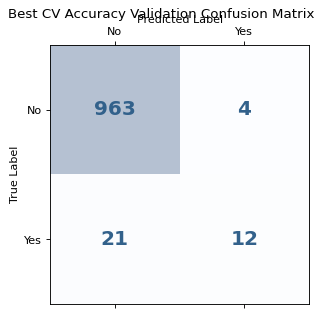

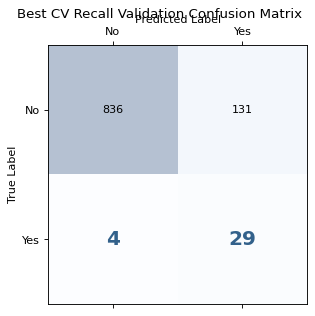

In [ ]:
# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true=y_test, y_pred=log_rs.predict(X_test))
# use the pretty function to make it nicer
pretty_confusion_matrix(confmat, LE.classes_, 
                        "Best CV Accuracy Validation Confusion Matrix",
                        highlight_indexes=[FP_i,FN_i,TP_i,TN_i]
                       )

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true=y_test, y_pred=rec_model.predict(X_test))
# use the pretty function to make it nicer
pretty_confusion_matrix(confmat, LE.classes_, 
                        "Best CV Recall Validation Confusion Matrix",
                        highlight_indexes=[FN_i,TP_i]
                       )

For the cost of reducing the TN values and increase on the FP values, we had a certain improvement in terms of the unacceptable FN cases. FN means here the cases in which the person defaulted but the model predicts that the person do not default. Previosuly, our FN values are much larger than the TP ones but now we got TP = 29, FN = 4 and this results in certain improvement on the Recall value, the metric that we are using for the problem. As we discussed in the lecture, here FN is more expensive than the FP in this setting since predicting a person with default on loan as there is no default costs more than predicting a person without default on loan as there is a default.    

### 5.3.3. Resampling

We can change the distribution of the classes in our training data.

#### Under-Sampling

A fast way to balance the data is just to randomly select a subset of the data for each class so they have the number of datapoints found in the smallest class.

__Notes__

- `RandomUnderSampler` is part of the Imblearn package, which allows for a lot of techniques for working with imballanced data.
- There is a `resample` method in `scikit-learn` but Imblearn is a bit smoother to work with.

If you want to use a sampler in a model pipeline then you can use the pipeline from imblearn. Using a sampler in a pipeline ensure you wont be training and validating your data on a smaller/larger sample than normal and get unrepresentative results!

In [ ]:
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.under_sampling import RandomUnderSampler


log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomUnderSampler(random_state=123)),
    ("model", LogisticRegression(random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

us_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

us_log_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('sampler',
                                              RandomUnderSampler(random_state=123)),
                                             ('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=60,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fde3f852510>},
                   random_state=42, refit='recall', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

In [ ]:
us_log_rs_df = pd.DataFrame(us_log_rs.cv_results_)
us_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__C", 
                                                               "mean_test_recall", 
                                                               "std_test_recall"]].head()

,param_model__C,mean_test_recall,std_test_recall
42,0.050337,0.910000,0.059255
10,0.04157,0.910000,0.059255
58,0.058499,0.906667,0.056372
29,0.059499,0.906667,0.056372
56,0.106568,0.906667,0.056372


Based on the undersampler strategy, there is small improvement on the model based on the Recall value.  

---

### 🚩 Exercise 12

Create a similar pipeline for oversampling strategy for the imbalanced data. It is very similar what you observed above as in `log_pipe`

Hint: Consider now `from imblearn.over_sampling import RandomOverSampler` as a starting point.

After getting the results in a similar way, compare the performance in terms of undersampling or oversampling

#### Oversampling
Data can be oversampled easily by randomly sampling from minority classes with replacement to duplicate original samples. 

Note:
make sure to oversample after splitting the training and validation sets or you may "bleed" information into the validation sets of the model when trying to test a model

In-other-words, make sure it is in a pipeline!

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(random_state=123)

log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", oversampler),
    ("model", LogisticRegression(random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1]),}

os_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

os_log_rs.fit(X_train, y_train)

os_log_rs_df = pd.DataFrame(os_log_rs.cv_results_)
os_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__C", 
                                                               "mean_test_recall", 
                                                               "std_test_recall"]].head()

,param_model__C,mean_test_recall,std_test_recall
49,0.405308,0.9,0.05164
14,0.388638,0.9,0.05164
32,0.077002,0.9,0.05164
31,0.332283,0.9,0.05164
29,0.059499,0.9,0.05164


In terms of the oversampled data, the mean of recall on the testing data is a bit smaller than the result of the undersampling case that we observed above. 
For this imbalanced data set, the use of undersampling is more beneficial for the improvement of recall value

---
# 3 Multi-class Logistic Regression


For this part, basically we will use the iris data, already available to use and it has nice properties in terms of class size 

In [ ]:
# First load the data here
from sklearn.datasets import load_iris

# Loading data
raw_data = load_iris()
data_desc = raw_data.DESCR
data = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)

# Some information on data set 
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000



Since we will be attempting to predict the species of flower which is a finite list of categorical options (ie. Setosa, Virginica, Versicolor), we need to assign a numerical value for each of the species within dummy variables. Dummy variables are variables that take binary (True=1, False=0) assignments based on every category in a given column. For example, our categories are Setosa, Virginica and Versicolor. We will have a column for each of these species and will assign a 1 or 0 for each row depending on what species they are. So a sample row representing Setosa, will have the Setosa column value of 1 and the Virginica and Versicolor values would be assigned as 0.

In [ ]:
# Consider species_label function as a helper 

# data = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)
data['species'] = [species_label(theta) for theta in raw_data.target]
#data['species_id'] = raw_data.target
print(data.head())

# Class size information
print(data.species.value_counts())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  
setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64


Some Visual Inspection on the data set

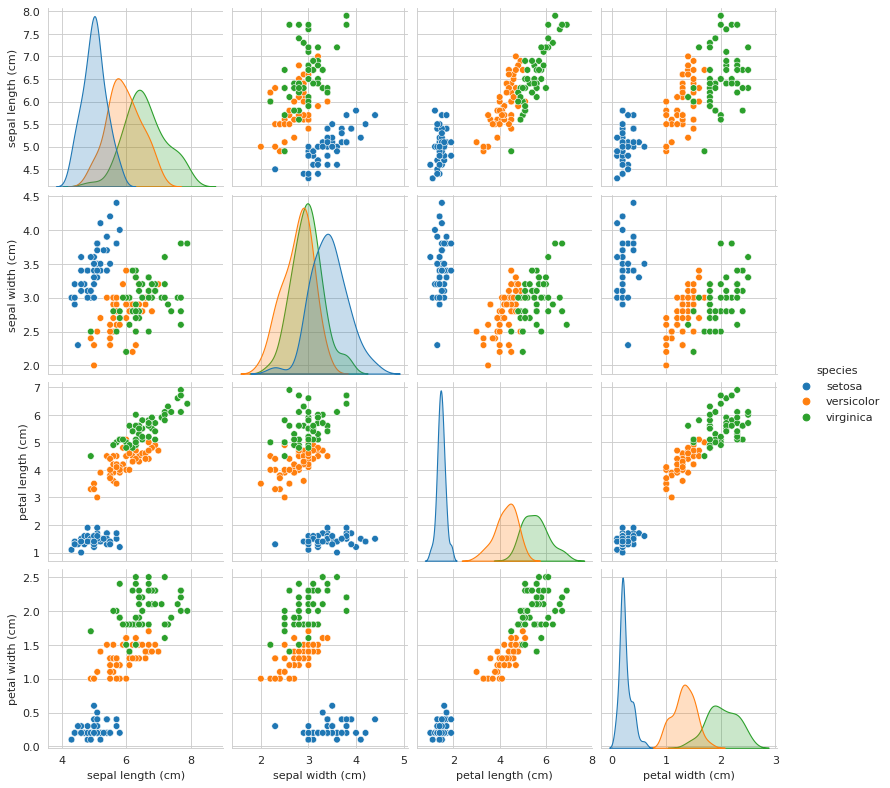

In [ ]:
sns.set_style('whitegrid')
sns.pairplot(data, hue='species')
plt.show()

In [ ]:
#Prepare the data set

#Encoding Species columns (to numerical values)
data['species'] = data['species'].astype('category').cat.codes
print(data['species'])
#Feature & Target Selection
#features = data.select_dtypes('float').columns
#target = ['species']

# X = feature values, all the columns except the last column
X = data.iloc[:, :-1]
print(X.head())

# y = target values, last column of the data frame
y = data.iloc[:, -1]

print(y.head())

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: species, Length: 150, dtype: int8
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
0    0
1    0
2    0
3    0
4    0
Name: species, dtype: int8


---

### 🚩 Exercise 13

1. Partition your data set into training and testing with %80-%20 ratio 
3. Create One-Vs-Rest Logistic Regression pipeline and train your model
4. Create Multinomial Logistic Regression pipeline and train your model

In [ ]:
#SK Learn Libraries
import sklearn
from sklearn.multiclass import OneVsRestClassifier   # 1vsRest Classifiers
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
#Split Parameters
test_size = 0.2

#Dataset Split over training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 

#Reset Index
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#Some insight on the selected data set 
X_train.head(), X_test.head(), y_train.head(), y_test.head() 

(    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 22                4.6               3.6                1.0               0.2
 15                5.7               4.4                1.5               0.4
 65                6.7               3.1                4.4               1.4
 11                4.8               3.4                1.6               0.2
 42                4.4               3.2                1.3               0.2,
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0                6.1               2.8                4.7               1.2
 1                5.7               3.8                1.7               0.3
 2                7.7               2.6                6.9               2.3
 3                6.0               2.9                4.5               1.5
 4                6.8               2.8                4.8               1.4,
 22    0
 15    0
 65    1
 11    0
 42    0
 Name: species, dtype: 

Under this method/strategy a multi-class classification dataset (in our case IRIS) is split into multiple binary classification chunks/datasets. Then a binary classifier (in our case SVC) is trained on each of the binary classification datasets and a prediction(s) is made using the model that has the most confidence value. The IRIS dataset will be split into individual datasets for each Species versus every other Species. Following are the details:

1. Binary Classification: setosa vs versicolor
2. Binary Classification: setosa vs virginica
3. Binary Classification: versicolor vs virginica

Side Not: The **OneVsRestClassifier** class is very easy to use and requires that a classifier that is to be used for binary classification be provided to the **OneVsRestClassifier** as an argument.

OneVsRestClassifier(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('sampler',
                                               RandomOverSampler(random_state=123)),
                                              ('model',
                                               LogisticRegression(random_state=42))]))


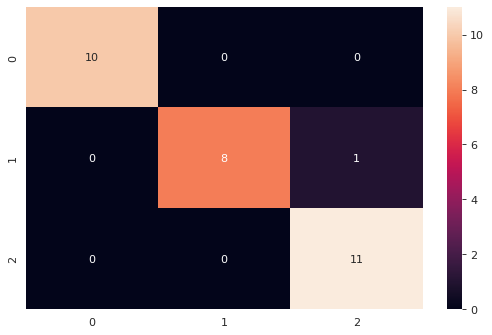

In [ ]:

#Define 1-vs-Rest Strategy / Classifier
# Recall the logistic pipeline as a model
ovr = OneVsRestClassifier(log_pipe)
print(ovr)

#fit model to training data
ovr.fit(X_train, y_train)

#Predictions
ovr_pred = ovr.predict(X_test)
ovr_pred

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = ovr_pred)

confmat

# OR with seaborn as a heat map
import seaborn as sns
sns.heatmap(confmat, annot=True)


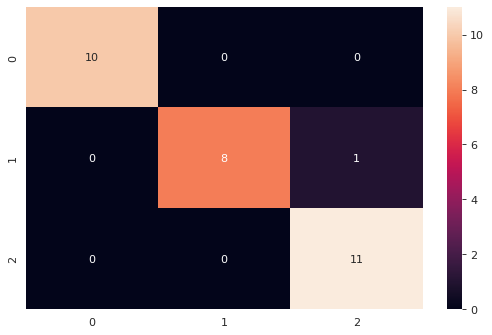

In [ ]:
# Rather than using the OneVsRestClassifier module one can define the same thing
# with the first pipeline that we observed 

log_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(random_state=42, multi_class = "ovr"))])

log_pipe.fit(X_train, y_train)

# use the first classifier to predict the validation set    
predictions = log_pipe.predict(X_test)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = predictions)
# confmat

import seaborn as sns
sns.heatmap(confmat, annot=True)


---

### 🚩 Exercise 14

1. Test the performance of one-vs-rest and multinomial logistic models
2. Derive the confusion matrix for each model

In [ ]:
from sklearn.model_selection import cross_validate

model_dict = {
    "log_ovr": LogisticRegression(random_state=42, multi_class = "ovr"),
    "log_multi": LogisticRegression(random_state=42, multi_class = "multinomial")
    }

for model_name in model_dict:
    linear_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model_dict[model_name])])
    
    #Applying Cross-validation with 5-fold
    scores = tidy_scores(cross_validate(linear_pipe, X_train, y_train, cv = 5, return_train_score = True))
    print(scores.loc[['mean', 'sd']])

    predictions = log_pipe.predict(X_test)
    confmat = confusion_matrix(y_true=y_test, y_pred=predictions)
    print(confmat)

    print("F1 score for", f1_score(y_test, predictions, average = "weighted"))
    # sns.heatmap(confmat, annot=True)

      fit_time  score_time  val_score  train_score
fold                                              
mean      0.04        0.01       0.90         0.94
sd        0.01        0.01       0.09         0.02
[[10  0  0]
 [ 0  8  1]
 [ 0  0 11]]
F1 score for 0.9664109121909632
      fit_time  score_time  val_score  train_score
fold                                              
mean      0.05        0.01       0.96         0.97
sd        0.01        0.00       0.05         0.01
[[10  0  0]
 [ 0  8  1]
 [ 0  0 11]]
F1 score for 0.9664109121909632


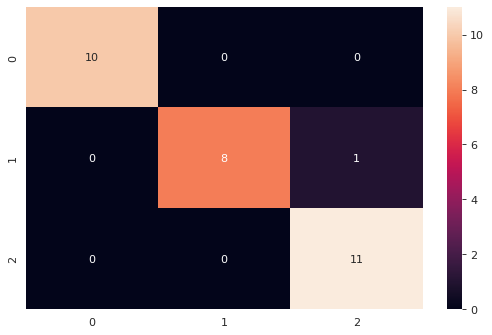

In [ ]:
import seaborn as sns
sns.heatmap(confmat, annot=True)


Both approaches are performing quite well and they resulted in equaivalent F1 score results for one-vs-rest and multinomial cases. The only misclassified observation is that the prediction of class label 1 as a class label 2 above 


---

## 4. Regularization on logistic regression

Note that regularized logistic regression is implemented using the ‘liblinear’ library, ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ solvers in scikits-learn. Note that regularization is applied by default as $L_2$.

So, to compare logistic regression without any regularization, play with the parameters of `LogisticRegression` function.



### 4.1 Without regularization

---

### 🚩 Exercise 15

1. Rebuild your best model as a result of Exercise 8 without any regularization
2. Derive the confusion matrix for the obtained model

In [ ]:
from sklearn.model_selection import cross_validate

model_dict = {
    "log_ovr_noreg": LogisticRegression(penalty = "none", random_state=42, multi_class = "ovr"),
    "log_multi_noreg": LogisticRegression(penalty = "none", random_state=42, multi_class = "multinomial")
    }

for model_name in model_dict:
    linear_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model_dict[model_name])])
    
    # Applying Cross-validation with 5-fold
    scores = tidy_scores(cross_validate(linear_pipe, X_train, y_train, cv = 5, return_train_score = True))
    print(scores.loc[['mean', 'sd']])

    predictions = log_pipe.predict(X_test)
    confmat = confusion_matrix(y_true=y_test, y_pred=predictions)
    print(confmat)

    print("F1 score for", f1_score(y_test, predictions, average = "weighted"))
    # sns.heatmap(confmat, annot=True)

      fit_time  score_time  val_score  train_score
fold                                              
mean      0.02         0.0       0.95         0.98
sd        0.00         0.0       0.06         0.02
[[10  0  0]
 [ 0  8  1]
 [ 0  0 11]]
F1 score for 0.9664109121909632
      fit_time  score_time  val_score  train_score
fold                                              
mean      0.02         0.0       0.95         0.99
sd        0.00         0.0       0.06         0.01
[[10  0  0]
 [ 0  8  1]
 [ 0  0 11]]
F1 score for 0.9664109121909632


For the given data set, even if there is no regularization, the benchmark classical logistic regression performs well enough in terms of both approaches. The one miss-classified class is the same that we observed above in the $L_2$ default regularized version

## EXTRA: CV and Parameter tuning 

Now, different regularized model with RandomizedSearchCV is implemented 
for the default data by using undersampling strategy to see the outputs. 



In [ ]:
# Putting all together for default data with
# Feature matrix and response separation 
data_x, data_y = df_default.drop(['default'], axis=1), df_default['default']

print(data_x.shape)
print(data_y.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_x.values, data_y.values, stratify = data_y, 
                                                    test_size = 0.1, random_state=42)

# The same proportion is satisfied for both train and test data sets 
print(pd.Series(y_train).value_counts(normalize=True)*100)
print(pd.Series(y_test).value_counts(normalize=True)*100)

#Converting the response variable 

from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_val = LE.transform(y_val)
y_test = LE.transform(y_test)


In [ ]:
# Create different classifiers with various options 
classifiers = {
    'L1 logistic (Multinomial)': LogisticRegression(C=C, penalty='l1',
                                                    multi_class='auto',
                                                    max_iter=1000),
               
    'L2 logistic (Multinomial)': LogisticRegression(C=C, penalty='l2',
                                                    multi_class='auto',
                                                    max_iter=1000),
               
    'L1 logistic (OvR)': LogisticRegression(C=C, penalty='l1',
                                            multi_class='auto',
                                            max_iter=1000),
               
    'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2',
                                            multi_class='auto',
                                            max_iter=1000)
}


---

Add your text solution here

In [ ]:
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.under_sampling import RandomUnderSampler


for model_name in classifiers:
  log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomUnderSampler(random_state=123)),
    ("model", classifiers[model_name])])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

us_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1", "recall", "precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)
#us_log_rs
us_log_rs.fit(X_train, y_train)

In [ ]:
us_log_rs_df = pd.DataFrame(us_log_rs.cv_results_)

us_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__C", 
                                                               "mean_test_recall", 
                                                               "std_test_recall"]].head()

---

## 7. Competing the worksheet

At this point you have hopefully been able to complete all the preceeding exercises. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Once that is done and you are happy with everything, you can generate your PDF and turn it in on gradescope under the `mlp-week07` assignment.